## Analysing model performance

This notebook reproduces the model performance analysis from the section _Model fit to human behaviour varies with recurrence and size_. Model average performances are calculated and compared using an ANOVA.

In [14]:
## preamble

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as st
from io import StringIO
from scipy.stats import pearsonr

In [10]:
# read the DNN data
nndf = pd.read_csv('../data/nn_data.csv')
# read the human data
hdf = pd.read_csv('../data/human_data.csv')

In [11]:
# make an aggregate DNN accuracy dataframe
aovdf = nndf.groupby(['model', 'seed'], as_index=False)['acc'].mean()

# run a one-way anova from DNN data on accuracy based on a model formula
formula = 'acc ~ C(model)'
model = ols(formula, aovdf).fit()
# print the results
print('One-way ANOVA on accuracy with model as factor\n', sm.stats.anova_lm(model, typ = 2))

One-way ANOVA on accuracy with model as factor
             sum_sq     df           F         PR(>F)
C(model)  0.627252   12.0  474.635187  5.642649e-163
Residual  0.027202  247.0         NaN            NaN


In [19]:
# Run a Tukey posthoc analysis on the 1way anova
tukey_test = pairwise_tukeyhsd(endog=aovdf['acc'], groups=aovdf['model'], alpha=0.05)
# turn the summary table into a dataframe for better visualisation
data = tukey_test.summary().as_csv()
rows = data.split('\n')[2:]
header = 'group1,group2,meandiff,p-adj,lower,upper,reject\n'
data = header + '\n'.join(rows)
tukey_df = pd.read_csv(StringIO(data), sep=',', skipinitialspace=True)
# print the results
print('Posthoc comparisons of model performance\n', tukey_df)

Posthoc comparisons of model performance
             group1          group2  meandiff   p-adj   lower   upper  reject
0   BLT_net_128     BL_net_128       -0.0187  0.0000 -0.0298 -0.0076  True  
1   BLT_net_128     BT_net_128       -0.0047  0.9690 -0.0158  0.0064  False 
2   BLT_net_128     B_net_128        -0.0629  0.0000 -0.0740 -0.0518  True  
3   BLT_net_128     CORnet_RT        -0.0146  0.0012 -0.0257 -0.0035  True  
4   BLT_net_128     FBnet            -0.0264  0.0000 -0.0375 -0.0153  True  
..             ...             ...       ...     ...     ...     ...     ...
73  cornet_s        vgg11_bn_small   -0.0448  0.0000 -0.0559 -0.0337  True  
74  cornet_s        vgg16_bn          0.0180  0.0000  0.0069  0.0291  True  
75  cornet_z        vgg11_bn_small    0.1080  0.0000  0.0969  0.1191  True  
76  cornet_z        vgg16_bn          0.1708  0.0000  0.1597  0.1819  True  
77  vgg11_bn_small  vgg16_bn          0.0628  0.0000  0.0517  0.0739  True  

[78 rows x 7 columns]


### Plots

Here we reproduce the plots from the results section _Model fit to human behaviour varies with recurrence and size_.

First we make a **barplot of average model performance**, then we make a scatterplot of model average performance per model parameter size.

In [6]:
# Extract average human performance to show a noise ceiling on the plots
hum_avg_perf = hdf['acc'].mean()

In [22]:
# define some labels & information
models_sizes= {'cornet_z': 1562760, 'cornet_V1_V1': 1599880, 'cornet_IT_IT': 3924104, 'CORnet_RT': 4700040, 'TDnet': 8183624, 'FBnet': 11831944, 'cornet_s': 52907720, 'B_net_128': 8291720, 'BL_net_128': 17257864, 'BT_net_128': 12592520, 'BLT_net_128': 21558664, 'vgg11_bn_small': 9426696, 'vgg16_bn': 134301768}
models = ['cornet_z', 'cornet_V1_V1', 'cornet_IT_IT', 'CORnet_RT', 'TDnet', 'FBnet', 'cornet_s', 'B_net_128', 'BL_net_128', 'BT_net_128', 'BLT_net_128', 'vgg11_bn_small', 'vgg16_bn']
models_palette = {'cornet_z': '#E5D5DA', 'cornet_V1_V1': '#D78282', 'cornet_IT_IT': '#ED6E33', 'CORnet_RT': '#F2B0CA', 'TDnet': '#F06599', 'FBnet': '#CA1E49', 'cornet_s': '#B849B5', 'B_net_128': '#D7E6F4', 'BL_net_128': '#97CEE3', 'BT_net_128': '#A5ACD7', 'BLT_net_128': '#4062AE', 'vgg11_bn_small': '#A7D27B', 'vgg16_bn': '#0F9948'}
models_names = {'cornet_z': 'C', 'cornet_V1_V1': 'C V1-V1', 'cornet_IT_IT': 'C IT-IT', 'CORnet_RT': 'CL', 'TDnet': 'CT', 'FBnet': 'CLT', 'cornet_s': 'CS', 'B_net_128': 'B', 'BL_net_128': 'BL', 'BT_net_128': 'BT', 'BLT_net_128': 'BLT', 'vgg11_bn_small': 'VGG11', 'vgg16_bn': 'VGG16'}

In [32]:
# define a function to extract a confidence interval range - useful for plotting
def get_CI_range(data, confidence=0.95):
    '''
    Output:
        Difference between the mean and the lower boundary of the 95% CI around the mean.
    '''
    confidence_interval = st.norm.interval(
        alpha=confidence,
        loc=np.mean(data),
        scale=st.sem(data)
    )
    
    interval = np.mean(data) - confidence_interval[0]
    
    return interval

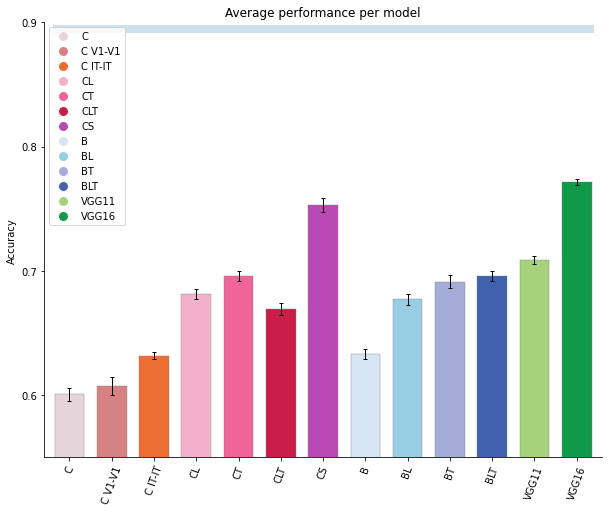

In [41]:
# barplot of average performance per model
fig, ax = plt.subplots(figsize=(10.0, 8.0))
plt.locator_params(axis = 'y', nbins=5)

# Create the bar plot values
x_values = range(len(models))
y_values = [np.mean(aovdf.loc[aovdf['model']==m, 'acc']) for m in models]
# calculate a confidence interval for each model
yerr = [get_CI_range(aovdf.loc[aovdf['model']==m, 'acc'])for m in models]

# Plot them on bars
bars = ax.bar(
    x=x_values,
    height=y_values,
    width=0.7,
    color=models_palette.values(),
    yerr = yerr,
    edgecolor='gray',
    linewidth=0.4,
    error_kw=dict(lw=1, capsize = 2.0),
)
# Change the axes
ax.set_ylim(0.55, 0.9)
max_x = len(models) - 0.4
ax.set_xlim(-0.6, max_x)
ax.set_xlabel(None)
ax.set_ylabel('Accuracy')
ax.set_xticks(ticks=x_values, labels=models_names.values(), rotation=70)

# give a title to the plot
plt.title('Average performance per model')

# remove the top and right frame lines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a horizontal line for human average performance
plt.hlines(y=hum_avg_perf, xmin=-0.4, xmax=max_x - 0.2, color='#CDE1EE', linewidth=8)


Next, we plot **model average performance per model size**.

Having checked our model performances and which model performs significantly better, we start by **correlating model size with performance**.

In [47]:
# calculate the correlation between model size and model performance
model_sizes = [models_sizes[m] for m in models]
model_performances = [np.mean(aovdf.loc[aovdf['model']==m, 'acc']) for m in models]
corr = pearsonr(model_sizes, model_performances)
# print the results
print(f'The Pearson\'s R correlation between model size and performance is {corr[0]}.')

The Pearson's R correlation between model size and performance is 0.7446527359737221


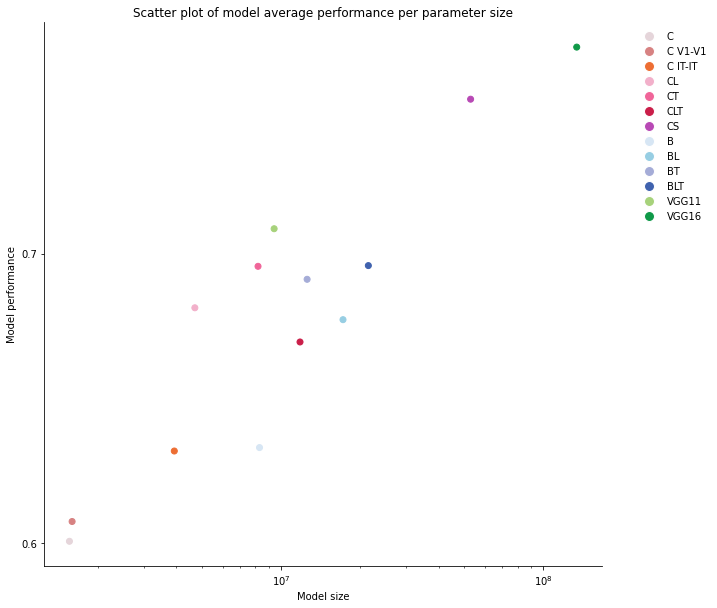

In [45]:
# scatterplot of model performance per model size
fig, ax = plt.subplots(figsize=(10.0, 10.0))
plt.locator_params(axis = 'y', nbins=3)

# Change the axes
ax.set_xlabel('Model size')
ax.set_ylabel('Model performance')
ax.set_xscale('log')

# make the scatter plot
ax.scatter(
    x = model_sizes,
    y = model_performances,
    c = [models_palette[m] for m in models]
)

# give the plot a title
plt.title('Scatter plot of model average performance per parameter size')

# remove the top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add a legend with model colour
legend_handles = []
for model in models_names:
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=models_palette[model], markersize=10, label=models_names[model]))

# Add the legend with custom handles
ax.legend(handles=legend_handles, frameon = False, bbox_to_anchor=(1.05, 1))